In [1]:
import torch
from transformers import RobertaConfig, RobertaForMaskedLM, RobertaTokenizer
import argparse
import json
import os
import pandas as pd
import numpy as np 
from tqdm import tqdm
from scipy import stats
import javalang
from captum.attr import LayerIntegratedGradients, TokenReferenceBase, visualization
from captum.attr import IntegratedGradients, LayerConductance, LayerIntegratedGradients, LayerActivation
from captum.attr import configure_interpretable_embedding_layer, remove_interpretable_embedding_layer
import pickle

if torch.__version__ >= '1.7.0':
    norm_fn = torch.linalg.norm
else:
    norm_fn = torch.norm

In [2]:
def get_cloze_words(filename, tokenizer):
    with open(filename, 'r', encoding='utf-8') as fp:
        words = fp.read().split('\n')
    idx2word = {tokenizer.encoder[w]: w for w in words}
    return idx2word

def read_answers(filename):
    answers = {}
    with open(filename, 'r', encoding='utf-8') as f:
        for line in f.readlines():
            line = line.strip()
            answers[line.split('<CODESPLIT>')[0]] = line.split('<CODESPLIT>')[1]
    return answers

def summarize_attributions(attributions):
    attributions = attributions.sum(dim=-1).squeeze(0)
    attributions = attributions / norm_fn(attributions)
    return attributions

def construct_whole_bert_embeddings(input_ids, ref_input_ids):
    input_embeddings = interpretable_embedding.indices_to_embeddings(input_ids)
    ref_input_embeddings = interpretable_embedding.indices_to_embeddings(ref_input_ids)
    
    return input_embeddings, ref_input_embeddings

In [3]:
def predict_forward_func(input_embeddings, tokenized_text):
    output = model(inputs_embeds=input_embeddings)
    if tokenizer.mask_token_id not in tokenized_text:
        print("Mask token not in tokenized text")
    index = tokenized_text.index(tokenizer.mask_token_id)
    # print("[MASK] Index: {}, length of tokenized text is {}".format(index, len(tokenized_text)))
    if index > output.logits.shape[1]:
        print("Length of output is {} and index is {}".format(output.logits.shape[1], index))
    output_list = output.logits[0][index]
    output_list = output_list.unsqueeze(0)
    
    return output_list.max(1).values

In [10]:
def get_CLS_attribution(model, tokenizer, codes):
    # layer x head x code
    cls_data = [[[] for col in range(12)] for row in range(12)]
    with torch.no_grad():
        failed = 0
        for code in tqdm(codes):
            # try:
                
            tokenized_text = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(code))
            input_ids = torch.tensor([tokenized_text]).to(device)
            reference_indices = token_reference.generate_reference(input_ids.shape[1], device=device).unsqueeze(0)

            layer_attrs = []
            layer_attn_mat = []
            input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, reference_indices)

            for i in range(model.config.num_hidden_layers):
                lc = LayerConductance(predict_forward_func, 
                                    model.roberta.encoder.layer[i])
                layer_attributions = lc.attribute(inputs=input_embeddings, 
                                                        baselines=ref_input_embeddings, 
                                                        additional_forward_args=(tokenized_text))
                layer_attrs.append(summarize_attributions(layer_attributions[0]))
                layer_attn_mat.append(layer_attributions[1])
            # layer x seq_len
            layer_attrs = torch.stack(layer_attrs)
            # layer x batch x head x seq_len x seq_len
            layer_attn_mat = torch.stack(layer_attn_mat)
            for layer in range(12):
                for head in range(12):
                    cls_data[layer][head].append(layer_attn_mat[layer][0][head][:, 0:1].mean().cpu().detach().numpy())
            # except:
            #     failed += 1
    print("Failed: {}".format(failed))
    
    return cls_data

In [5]:
def get_SEP_attention(model, tokenizer, codes):
    sep_data = [[[] for col in range(12)] for row in range(12)]

    with torch.no_grad():
        failed = 0
        try:
            for code in tqdm(codes):
                tokenized_text = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(code))
                input_ids = torch.tensor([tokenized_text]).to(device)
                reference_indices = token_reference.generate_reference(input_ids.shape[1], device=device).unsqueeze(0)

                layer_attrs = []
                layer_attn_mat = []
                input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, reference_indices)

                for i in range(model.config.num_hidden_layers):
                    lc = LayerConductance(predict_forward_func, 
                                        model.roberta.encoder.layer[i])
                    layer_attributions = lc.attribute(inputs=input_embeddings, 
                                                            baselines=ref_input_embeddings, 
                                                            additional_forward_args=(tokenized_text))
                    layer_attrs.append(summarize_attributions(layer_attributions[0]))
                    layer_attn_mat.append(layer_attributions[1])
                # layer x seq_len
                layer_attrs = torch.stack(layer_attrs)
                # layer x batch x head x seq_len x seq_len
                layer_attn_mat = torch.stack(layer_attn_mat)
                for layer in range(12):
                    for head in range(12):
                        for each_sep_index in torch.where(input_ids[0]==2)[0].cpu().detach().numpy():
                            sep_data[layer][head].append(layer_attn_mat[layer][0][head][:, each_sep_index].mean().cpu().detach().numpy()) 
        except:
            failed += 1
    print("Failed: {}".format(failed))
    return sep_data

In [36]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('Runing on device:', device)
MODEL_CLASSES = {'roberta': (RobertaConfig, RobertaForMaskedLM, RobertaTokenizer)}

config_class, model_class, tokenizer_class = MODEL_CLASSES['roberta']
config = config_class.from_pretrained('roberta-base')
tokenizer = tokenizer_class.from_pretrained('roberta-base')

model = RobertaForMaskedLM.from_pretrained('microsoft/codebert-base-mlm', 
                                        output_attentions=True, output_hidden_states=True)
model.to(device)

ref_token_id = tokenizer.pad_token_id # A token used for generating token reference
sep_token_id = tokenizer.sep_token_id # A token used as a separator between question and text and it is also added to the end of the text.
cls_token_id = tokenizer.cls_token_id # A token used for prepending to the concatenated question-text word sequence

token_reference = TokenReferenceBase(reference_token_idx=ref_token_id)

cloze_results = []
cloze_words_file = '../data/cloze-all/cloze_test_words.txt'
file_path = '../data/cloze-all/java/clozeTest.json'

idx2word = get_cloze_words(cloze_words_file, tokenizer)

lines = json.load(open(file_path))

print('Total number of code instances: ', len(lines))

answer_file = '../evaluator/answers/java/answers.txt'
answers = read_answers(answer_file)
answer_list = list(answers.values())

bestSampleWithMaxPairLength = []
bestSampleWithMaxPairLength_LEN =[]

number_of_samples = 2000 # a small set of data for testing
for i in range(len(lines[:number_of_samples])):
    code = ' '.join(lines[i]['pl_tokens'])
    bestStr = "<s> " + code + " </s>"
    bestLen = len(bestStr.split(" "))
    bestSampleWithMaxPairLength.append(bestStr)
    bestSampleWithMaxPairLength_LEN.append(bestLen)
    
lengths=[]
codes=[]
selected_answers = []

for index, code in enumerate(bestSampleWithMaxPairLength):
    l = len(tokenizer.tokenize(code))
    if l<=256:
        lengths.append(l)
        codes.append(code)
        selected_answers.append(answer_list[index])
        
print('Selected number of codes: ', len(codes))
print('Selected number of answers: ', len(selected_answers))

Runing on device: cuda:0
Total number of code instances:  40492
Selected number of codes:  1753
Selected number of answers:  1753


In [37]:
interpretable_embedding = configure_interpretable_embedding_layer(model, 'roberta.embeddings.word_embeddings')

/home/fjiriges/anaconda3/envs/cuBERT/lib/python3.8/site-packages/captum/attr/_models/base.py:188: UserWarning: In order to make embedding layers more interpretable they will be replaced with an interpretable embedding layer which wraps the original embedding layer and takes word embedding vectors as inputs of the forward function. This allows us to generate baselines for word embeddings and compute attributions for each embedding dimension. The original embedding layer must be set back by calling `remove_interpretable_embedding_layer` function after model interpretation is finished. 
  warnings.warn(


In [38]:
CLS_atten_correct = get_CLS_attribution(model, 
                                        tokenizer, 
                                        codes)

100%|██████████| 1753/1753 [53:24<00:00,  1.83s/it] 

Failed: 0


In [39]:
a = np.array(CLS_atten_correct)
a.shape

(12, 12, 1753)

In [56]:
CLS_attri_avg = np.max(a, axis=2)

In [41]:
SEP_attribution = get_SEP_attention(model, 
                                        tokenizer, 
                                        codes)

100%|██████████| 1753/1753 [54:38<00:00,  1.87s/it] 

Failed: 0


In [57]:
SEP_attri_avg = np.max(np.array(SEP_attribution), axis=2)

In [43]:
avg_attns = {}
avg_attns = {'cls': CLS_attri_avg, 'sep': SEP_attri_avg}

In [44]:
#!pip install filelock more_itertools
import pandas as pd
import numpy as np 
#import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
np.random.seed(0)
import seaborn as sns
RED = "#e74c3c"
import collections
import pickle

import matplotlib
import numpy as np
import seaborn as sns
import sklearn

from matplotlib import pyplot as plt
from matplotlib import cm
from sklearn import manifold

sns.set_style("darkgrid")
# Pretty colors
BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"

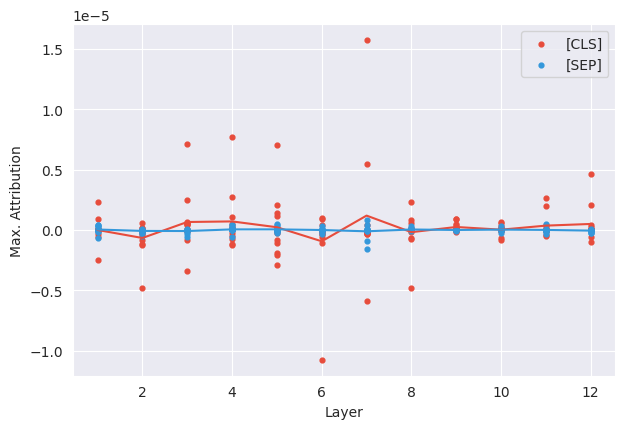

In [58]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs


## thi is with 2 enfding functions

def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Max. Attribution")


plt.figure(figsize=(7, 21))
ax = plt.subplot(4, 1, 1)
for key, color, label in [ ("cls", RED, "[CLS]"),("sep", BLUE, "[SEP]")]:
  add_line(key, ax, color, label)

## Average Attribution Scores on Syntactic Types

In [46]:
def get_syntax_types_for_code(code_snippet):
  types = ["[CLS]"]
  code = ["<s>"]
  tree = list(javalang.tokenizer.tokenize(code_snippet))
  
  for i in tree:
    j = str(i)
    j = j.split(" ")
    if j[1] == '"MASK"':
      types.append('[MASK]')
      code.append('<mask>')
    else:
      types.append(j[0].lower())
      code.append(j[1][1:-1])
    
  types.append("[SEP]")
  code.append("</s>")
  return np.array(types), ' '.join(code)

def get_start_end_of_token_when_tokenized(code, types, tokenizer):
  reindexed_types = []
  start = 0
  end = 0
  for index, each_token in enumerate(code.split(" ")):
    tokenized_list = tokenizer.tokenize(each_token)
    for i in range(len(tokenized_list)):
      end += 1
    reindexed_types.append((start, end-1))
    start = end
  return reindexed_types

def getInstanceSyntaxAttributionScore(codes, tokenizer, syntaxList):
    all_instances = []

    with torch.no_grad():
        for eachCode in tqdm(codes):
            try:
                Instantce_Result = {}
                for syntaxType in syntaxList:
                    Instantce_Result[syntaxType] = []
                    
                cleancode = eachCode.replace("<s> ", "").replace(" </s>", "").replace('<mask>', 'MASK')
                types, rewrote_code = get_syntax_types_for_code(cleancode)
                # send input to model
                tokenized_text = tokenizer.convert_tokens_to_ids(tokenizer.tokenize(rewrote_code))
                input_ids = torch.tensor([tokenized_text]).to(device)
                # get reference indices
                reference_indices = token_reference.generate_reference(input_ids.shape[1], device=device).unsqueeze(0)
                # get layer attribution
                layer_attrs = []
                layer_attn_mat = []
                input_embeddings, ref_input_embeddings = construct_whole_bert_embeddings(input_ids, reference_indices)
                for i in range(model.config.num_hidden_layers):
                    lc = LayerConductance(predict_forward_func, 
                                        model.roberta.encoder.layer[i])
                    layer_attributions = lc.attribute(inputs=input_embeddings, 
                                                            baselines=ref_input_embeddings, 
                                                            additional_forward_args=(tokenized_text))
                    layer_attrs.append(summarize_attributions(layer_attributions[0]))
                    layer_attn_mat.append(layer_attributions[1])
                # layer x seq_len
                layer_attrs = torch.stack(layer_attrs)
                # layer x batch x head x seq_len x seq_len
                layer_attn_mat = torch.stack(layer_attn_mat)
                # get start and end index of each token
                start_end = get_start_end_of_token_when_tokenized(rewrote_code, types, tokenizer)
                
                for syntaxType in syntaxList:
                    attribution_scores = [[[] for col in range(12)] for row in range(12)]
                    for layer in range(12):
                        for head in range(12):
                            for each_sep_index in np.where(types==syntaxType)[0]:
                                start_index, end_index = start_end[each_sep_index]
                                interim_value = layer_attn_mat[layer][0][head][:, start_index:end_index+1].mean().cpu().detach().numpy()
                                if np.isnan(interim_value):
                                    pass
                                else: 
                                    attribution_scores[layer][head].append(interim_value)
                    
                    if np.array(attribution_scores).shape[2] != 0:
                        Instantce_Result[syntaxType].append(np.array(attribution_scores))

            except Exception as e:
                print(e)
            all_instances.append(Instantce_Result)

    return all_instances

In [47]:
syntax_list = ['annotation', 'basictype', 'boolean', 
            'decimalinteger', 'identifier', 'keyword',
            'modifier', 'operator', 'separator', 'null',
            'string', 'decimalfloatingpoint']

In [48]:
syntax_attributions = getInstanceSyntaxAttributionScore(codes, 
                                                        tokenizer, 
                                                        syntax_list)

  2%|▏         | 30/1753 [01:19<1:15:48,  2.64s/it]

Mask token not in tokenized text
50264 is not in list


  3%|▎         | 52/1753 [02:13<1:01:31,  2.17s/it]

Mask token not in tokenized text
50264 is not in list


  4%|▎         | 65/1753 [02:45<1:35:20,  3.39s/it]

Mask token not in tokenized text
50264 is not in list


  4%|▍         | 69/1753 [02:53<1:14:01,  2.64s/it]

Mask token not in tokenized text
50264 is not in list


  5%|▍         | 84/1753 [03:31<1:12:08,  2.59s/it]

Mask token not in tokenized text
50264 is not in list


  6%|▋         | 110/1753 [04:43<1:18:21,  2.86s/it]

Mask token not in tokenized text
50264 is not in list


  6%|▋         | 113/1753 [04:46<53:01,  1.94s/it]  

Mask token not in tokenized text
50264 is not in list


  7%|▋         | 119/1753 [05:03<1:08:10,  2.50s/it]

Mask token not in tokenized text
50264 is not in list


  7%|▋         | 124/1753 [05:11<58:52,  2.17s/it]  

Mask token not in tokenized text
50264 is not in list


  7%|▋         | 126/1753 [05:13<42:41,  1.57s/it]

Mask token not in tokenized text
50264 is not in list


  8%|▊         | 136/1753 [05:36<1:05:38,  2.44s/it]

Mask token not in tokenized text
50264 is not in list


  8%|▊         | 144/1753 [05:50<1:05:36,  2.45s/it]

Mask token not in tokenized text
50264 is not in list


  8%|▊         | 147/1753 [05:54<46:53,  1.75s/it]  

Mask token not in tokenized text
50264 is not in list


 10%|█         | 183/1753 [07:35<1:42:47,  3.93s/it]

Mask token not in tokenized text
50264 is not in list


 11%|█         | 187/1753 [07:46<1:27:37,  3.36s/it]

Mask token not in tokenized text
50264 is not in list


 11%|█         | 194/1753 [07:57<49:01,  1.89s/it]  

Mask token not in tokenized text
50264 is not in list


 12%|█▏        | 207/1753 [08:28<1:06:04,  2.56s/it]

Mask token not in tokenized text
50264 is not in list


 13%|█▎        | 220/1753 [09:05<1:10:58,  2.78s/it]

Mask token not in tokenized text
50264 is not in list


 14%|█▍        | 251/1753 [10:32<45:17,  1.81s/it]  

Mask token not in tokenized text
50264 is not in list


 18%|█▊        | 316/1753 [13:29<1:01:50,  2.58s/it]

Mask token not in tokenized text
50264 is not in list


 19%|█▉        | 335/1753 [14:19<1:27:22,  3.70s/it]

Mask token not in tokenized text
50264 is not in list


 19%|█▉        | 339/1753 [14:26<58:11,  2.47s/it]  

Mask token not in tokenized text
50264 is not in list


 20%|██        | 359/1753 [15:13<1:06:24,  2.86s/it]

Mask token not in tokenized text
50264 is not in list


 21%|██        | 371/1753 [16:00<2:06:18,  5.48s/it]

Mask token not in tokenized text
50264 is not in list


 22%|██▏       | 378/1753 [16:18<1:20:36,  3.52s/it]

Mask token not in tokenized text
50264 is not in list


 22%|██▏       | 384/1753 [16:30<59:40,  2.62s/it]  

Mask token not in tokenized text
50264 is not in list


 22%|██▏       | 391/1753 [16:41<42:44,  1.88s/it]

Mask token not in tokenized text
50264 is not in list


 23%|██▎       | 400/1753 [16:59<47:05,  2.09s/it]

Mask token not in tokenized text
50264 is not in list


 23%|██▎       | 409/1753 [17:20<1:05:20,  2.92s/it]

Mask token not in tokenized text
50264 is not in list


 24%|██▎       | 413/1753 [17:26<45:34,  2.04s/it]  

Mask token not in tokenized text
50264 is not in list


 25%|██▍       | 438/1753 [18:32<1:34:24,  4.31s/it]

Mask token not in tokenized text
50264 is not in list


 25%|██▌       | 441/1753 [18:38<1:09:02,  3.16s/it]

Mask token not in tokenized text
50264 is not in list


 25%|██▌       | 446/1753 [18:53<1:10:32,  3.24s/it]

Mask token not in tokenized text
50264 is not in list


 28%|██▊       | 487/1753 [20:42<43:56,  2.08s/it]  

Mask token not in tokenized text
50264 is not in list


 28%|██▊       | 496/1753 [21:12<1:16:38,  3.66s/it]

Mask token not in tokenized text
50264 is not in list


 29%|██▊       | 502/1753 [21:30<1:04:13,  3.08s/it]

Mask token not in tokenized text
50264 is not in list


 29%|██▉       | 507/1753 [21:42<54:26,  2.62s/it]  

Mask token not in tokenized text
50264 is not in list


 30%|██▉       | 523/1753 [22:23<1:15:20,  3.67s/it]

Mask token not in tokenized text
50264 is not in list


 30%|██▉       | 525/1753 [22:25<51:01,  2.49s/it]  

Mask token not in tokenized text
50264 is not in list


 31%|███       | 538/1753 [23:08<57:14,  2.83s/it]  

Mask token not in tokenized text
50264 is not in list


 31%|███       | 540/1753 [23:11<43:22,  2.15s/it]

Mask token not in tokenized text
50264 is not in list


 31%|███       | 545/1753 [23:18<32:34,  1.62s/it]

Mask token not in tokenized text
50264 is not in list


 32%|███▏      | 553/1753 [23:37<46:43,  2.34s/it]

Mask token not in tokenized text
50264 is not in list


 33%|███▎      | 571/1753 [24:20<38:08,  1.94s/it]  

Mask token not in tokenized text
50264 is not in list


 33%|███▎      | 576/1753 [24:32<44:24,  2.26s/it]

Mask token not in tokenized text
50264 is not in list


 36%|███▌      | 630/1753 [27:12<57:43,  3.08s/it]  

Mask token not in tokenized text
50264 is not in list


 37%|███▋      | 649/1753 [27:56<52:55,  2.88s/it]

Mask token not in tokenized text
50264 is not in list


 37%|███▋      | 655/1753 [28:13<59:33,  3.25s/it]

Mask token not in tokenized text
50264 is not in list


 38%|███▊      | 662/1753 [28:27<38:56,  2.14s/it]

Mask token not in tokenized text
50264 is not in list


 39%|███▉      | 686/1753 [29:28<39:13,  2.21s/it]  

Mask token not in tokenized text
50264 is not in list


 40%|███▉      | 701/1753 [30:05<58:30,  3.34s/it]  

Mask token not in tokenized text
50264 is not in list


 41%|████      | 714/1753 [30:43<59:31,  3.44s/it]  

Mask token not in tokenized text
50264 is not in list


 42%|████▏     | 737/1753 [31:42<44:35,  2.63s/it]  

Mask token not in tokenized text
50264 is not in list


 42%|████▏     | 739/1753 [31:45<36:22,  2.15s/it]

Mask token not in tokenized text
50264 is not in list


 43%|████▎     | 752/1753 [32:22<55:08,  3.31s/it]

Mask token not in tokenized text
50264 is not in list


 43%|████▎     | 761/1753 [32:53<49:10,  2.97s/it]  

Mask token not in tokenized text
50264 is not in list


 46%|████▌     | 801/1753 [34:52<52:50,  3.33s/it]  

Mask token not in tokenized text
50264 is not in list


 48%|████▊     | 838/1753 [36:20<51:29,  3.38s/it]

Mask token not in tokenized text
50264 is not in list


 48%|████▊     | 849/1753 [36:50<1:06:07,  4.39s/it]

Mask token not in tokenized text
50264 is not in list


 49%|████▊     | 853/1753 [36:59<49:40,  3.31s/it]  

Mask token not in tokenized text
50264 is not in list


 49%|████▉     | 856/1753 [37:06<41:33,  2.78s/it]

Mask token not in tokenized text
50264 is not in list


 50%|████▉     | 871/1753 [37:51<52:10,  3.55s/it]  

Mask token not in tokenized text
50264 is not in list


 50%|█████     | 882/1753 [38:22<39:16,  2.71s/it]

Mask token not in tokenized text
50264 is not in list


 52%|█████▏    | 907/1753 [39:44<41:53,  2.97s/it]  

Mask token not in tokenized text
50264 is not in list
Mask token not in tokenized text
50264 is not in list


 52%|█████▏    | 911/1753 [39:49<27:51,  1.98s/it]

Mask token not in tokenized text
50264 is not in list


 53%|█████▎    | 930/1753 [40:37<31:46,  2.32s/it]

Mask token not in tokenized text
50264 is not in list


 54%|█████▎    | 940/1753 [41:10<50:14,  3.71s/it]

Mask token not in tokenized text
50264 is not in list


 55%|█████▌    | 968/1753 [42:27<31:02,  2.37s/it]

Mask token not in tokenized text
50264 is not in list


 55%|█████▌    | 972/1753 [42:35<28:14,  2.17s/it]

Mask token not in tokenized text
50264 is not in list


 56%|█████▌    | 977/1753 [42:43<23:55,  1.85s/it]

Mask token not in tokenized text
50264 is not in list


 57%|█████▋    | 994/1753 [43:41<46:20,  3.66s/it]

Mask token not in tokenized text
50264 is not in list


 58%|█████▊    | 1016/1753 [44:41<46:47,  3.81s/it]

Mask token not in tokenized text
50264 is not in list


 59%|█████▊    | 1027/1753 [45:16<40:28,  3.35s/it]

Mask token not in tokenized text
50264 is not in list


 59%|█████▉    | 1042/1753 [45:58<42:32,  3.59s/it]

Mask token not in tokenized text
50264 is not in list


 60%|██████    | 1052/1753 [46:19<24:04,  2.06s/it]

Mask token not in tokenized text
50264 is not in list


 61%|██████    | 1069/1753 [47:00<31:21,  2.75s/it]

Mask token not in tokenized text
50264 is not in list


 61%|██████    | 1072/1753 [47:06<25:11,  2.22s/it]

Mask token not in tokenized text
50264 is not in list


 62%|██████▏   | 1081/1753 [47:24<24:37,  2.20s/it]

Mask token not in tokenized text
50264 is not in list
Mask token not in tokenized text
50264 is not in list


 62%|██████▏   | 1090/1753 [47:44<27:16,  2.47s/it]

Mask token not in tokenized text
50264 is not in list
Mask token not in tokenized text
50264 is not in list


 63%|██████▎   | 1097/1753 [47:58<26:29,  2.42s/it]

Mask token not in tokenized text
50264 is not in list


 63%|██████▎   | 1105/1753 [48:17<23:44,  2.20s/it]

Mask token not in tokenized text
50264 is not in list


 64%|██████▍   | 1125/1753 [49:28<44:49,  4.28s/it]

Mask token not in tokenized text
50264 is not in list


 66%|██████▌   | 1152/1753 [50:29<19:23,  1.94s/it]

Mask token not in tokenized text
50264 is not in list


 66%|██████▌   | 1159/1753 [50:52<30:02,  3.03s/it]

Mask token not in tokenized text
50264 is not in list


 66%|██████▋   | 1162/1753 [50:57<24:30,  2.49s/it]

Mask token not in tokenized text
50264 is not in list
Mask token not in tokenized text
50264 is not in list


 67%|██████▋   | 1174/1753 [51:27<24:44,  2.56s/it]

Mask token not in tokenized text
50264 is not in list


 67%|██████▋   | 1182/1753 [51:50<25:35,  2.69s/it]

Mask token not in tokenized text
50264 is not in list
Mask token not in tokenized text
50264 is not in list


 68%|██████▊   | 1187/1753 [51:57<19:17,  2.04s/it]

Mask token not in tokenized text
50264 is not in list


 68%|██████▊   | 1190/1753 [52:03<19:14,  2.05s/it]

Mask token not in tokenized text
50264 is not in list


 69%|██████▉   | 1207/1753 [52:54<27:53,  3.06s/it]

Mask token not in tokenized text
50264 is not in list


 70%|███████   | 1233/1753 [54:07<22:12,  2.56s/it]

Mask token not in tokenized text
50264 is not in list


 71%|███████   | 1242/1753 [54:42<33:26,  3.93s/it]

Mask token not in tokenized text
50264 is not in list


 72%|███████▏  | 1258/1753 [55:29<32:48,  3.98s/it]

Mask token not in tokenized text
50264 is not in list
Mask token not in tokenized text
50264 is not in list


 72%|███████▏  | 1261/1753 [55:31<17:43,  2.16s/it]

Mask token not in tokenized text
50264 is not in list


 72%|███████▏  | 1269/1753 [55:43<14:10,  1.76s/it]

Mask token not in tokenized text
50264 is not in list


 73%|███████▎  | 1280/1753 [56:12<18:53,  2.40s/it]

Mask token not in tokenized text
50264 is not in list


 76%|███████▋  | 1341/1753 [58:58<20:19,  2.96s/it]

Mask token not in tokenized text
50264 is not in list


 80%|███████▉  | 1394/1753 [1:01:48<21:07,  3.53s/it]

Mask token not in tokenized text
50264 is not in list


 80%|███████▉  | 1401/1753 [1:01:57<09:25,  1.61s/it]

Mask token not in tokenized text
50264 is not in list


 80%|████████  | 1403/1753 [1:01:58<06:34,  1.13s/it]

Mask token not in tokenized text
50264 is not in list


 81%|████████  | 1422/1753 [1:02:35<09:38,  1.75s/it]

Mask token not in tokenized text
50264 is not in list


 84%|████████▎ | 1466/1753 [1:03:50<06:31,  1.36s/it]

Mask token not in tokenized text
50264 is not in list


 84%|████████▍ | 1477/1753 [1:04:04<06:27,  1.40s/it]

Mask token not in tokenized text
50264 is not in list


 85%|████████▌ | 1496/1753 [1:04:39<11:32,  2.69s/it]

Mask token not in tokenized text
50264 is not in list


 86%|████████▌ | 1506/1753 [1:04:53<06:36,  1.61s/it]

Mask token not in tokenized text
50264 is not in list


 86%|████████▌ | 1508/1753 [1:04:57<07:39,  1.88s/it]

Mask token not in tokenized text
50264 is not in list


 88%|████████▊ | 1547/1753 [1:06:08<05:09,  1.50s/it]

Mask token not in tokenized text
50264 is not in list


 90%|█████████ | 1584/1753 [1:07:07<03:31,  1.25s/it]

Mask token not in tokenized text
50264 is not in list


 91%|█████████ | 1593/1753 [1:07:24<04:37,  1.74s/it]

Mask token not in tokenized text
50264 is not in list


 92%|█████████▏| 1621/1753 [1:08:18<02:47,  1.27s/it]

Mask token not in tokenized text
50264 is not in list


 93%|█████████▎| 1639/1753 [1:08:52<03:15,  1.72s/it]

Mask token not in tokenized text
50264 is not in list


 96%|█████████▌| 1675/1753 [1:10:03<01:46,  1.36s/it]

Mask token not in tokenized text
50264 is not in list


 97%|█████████▋| 1694/1753 [1:10:39<01:29,  1.52s/it]

Mask token not in tokenized text
50264 is not in list


 97%|█████████▋| 1703/1753 [1:10:55<01:16,  1.54s/it]

Mask token not in tokenized text
50264 is not in list


 97%|█████████▋| 1707/1753 [1:10:59<00:57,  1.24s/it]

Mask token not in tokenized text
50264 is not in list


 97%|█████████▋| 1709/1753 [1:11:02<01:04,  1.46s/it]

Mask token not in tokenized text
50264 is not in list


 98%|█████████▊| 1714/1753 [1:11:09<00:59,  1.52s/it]

Mask token not in tokenized text
50264 is not in list


 98%|█████████▊| 1718/1753 [1:11:15<01:04,  1.84s/it]

Mask token not in tokenized text
50264 is not in list


 99%|█████████▊| 1730/1753 [1:11:42<01:16,  3.34s/it]

Mask token not in tokenized text
50264 is not in list
Mask token not in tokenized text
50264 is not in list


 99%|█████████▉| 1743/1753 [1:11:56<00:10,  1.06s/it]

Mask token not in tokenized text
50264 is not in list


100%|█████████▉| 1748/1753 [1:12:02<00:06,  1.36s/it]

Mask token not in tokenized text
50264 is not in list


100%|██████████| 1753/1753 [1:12:08<00:00,  2.47s/it]


In [54]:
for syntaxType in syntax_list:
    temp = []
    for instance in syntax_attributions:
        if len(instance[syntaxType]) != 0:
            temp.append(np.array(instance[syntaxType]).squeeze(0).mean(axis=2))
    temp = np.array(temp)
    temp = temp.reshape(temp.shape[1], temp.shape[2], temp.shape[0])
    avg_temp = temp.mean(axis=2)
    avg_attns[syntaxType] = avg_temp
            

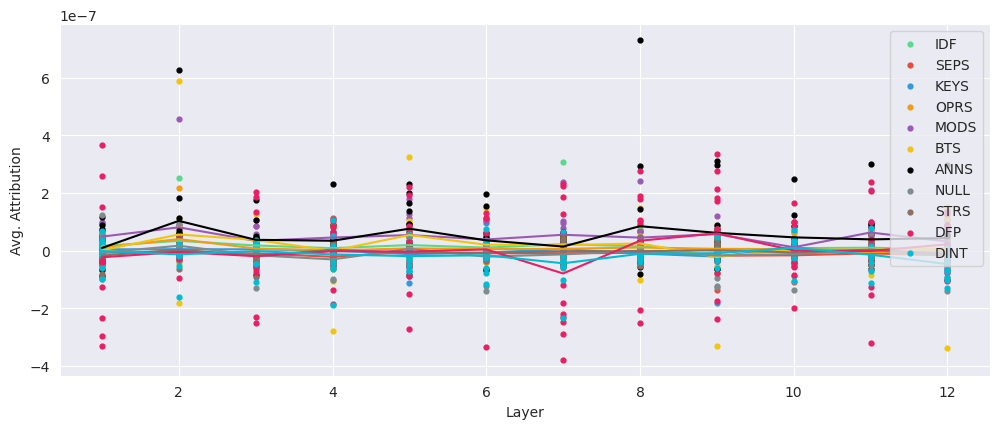

In [55]:
def get_data_points(head_data):
  xs, ys, avgs = [], [], []
  for layer in range(12):
    for head in range(12):
      ys.append(head_data[layer, head])
      xs.append(1 + layer)
    avgs.append(head_data[layer].mean())
  return xs, ys, avgs

def add_line(key, ax, color, label, plot_avgs=True):
  xs, ys, avgs = get_data_points(avg_attns[key])
  ax.scatter(xs, ys, s=12, label=label, color=color)
  if plot_avgs:
    ax.plot(1 + np.arange(len(avgs)), avgs, color=color)
  ax.legend(loc="best")
  ax.set_xlabel("Layer")
  ax.set_ylabel("Avg. Attribution")
  
  

BLACK = "k"
GREEN = "#59d98e"
SEA = "#159d82"
BLUE = "#3498db"
PURPLE = "#9b59b6"
GREY = "#95a5a6"
RED = "#e74c3c"
ORANGE = "#f39c12"
GRAY = "#7f8c8d"
BROWN = "#8d6e63"
PINK = "#e91e63"
CYAN = "#00bcd4"
YELLOW = "#f1c40f"

plt.figure(figsize=(12, 21))
ax = plt.subplot(4, 1, 1)
for key, color, label in [("identifier", GREEN, "IDF"),("separator", RED, "SEPS"), ("keyword", BLUE, "KEYS"), ("operator", ORANGE, "OPRS"), ("modifier", PURPLE, "MODS"), ("basictype", YELLOW, "BTS"), ("annotation", BLACK, "ANNS"), ("null", GRAY, "NULL"), ("string", BROWN, "STRS"), ("decimalfloatingpoint", PINK, "DFP"), ("decimalinteger", CYAN, "DINT")]:
  add_line(key, ax, color, label, plot_avgs=True)

In [35]:
avg_attns.keys()

dict_keys(['cls', 'sep', 'annotation', 'basictype', 'boolean', 'decimalinteger', 'identifier', 'keyword', 'modifier', 'operator', 'separator', 'null', 'string', 'decimalfloatingpoint'])